## Imports and paths

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from pathlib import Path

from IPython.display import Image, display, Video, HTML


In [1]:
!tree -L  3 ..

..
├── Benoit
│   ├── notebook_exploratory_data_analaysis_benoitfrisque.ipynb
│   └── video_conversion_benoitfrisque.ipynb
├── notebook_exploratory_data_analaysis_benoitfrisque.ipynb
└── video_conversion_benoitfrisque.ipynb

1 directory, 4 files


In [9]:
DATA_DIR         = Path('../../raw_data/asl-signs')
TRAIN_CSV_PATH   = DATA_DIR/'train.csv'
LANDMARK_DIR     = DATA_DIR/'train_landmark_files'
LABEL_MAP_PATH   = DATA_DIR/'sign_to_prediction_index_map.json'

## Data description

**Files**

**train_landmark_files/[participant_id]/[sequence_id].parquet** The landmark data. The landmarks were extracted from raw videos with the MediaPipe holistic model. Not all of the frames necessarily had visible hands or hands that could be detected by the model.

Landmark data should not be used to identify or re-identify an individual. Landmark data is not intended to enable any form of identity recognition or store any unique biometric identification.

- `frame` - The frame number in the raw video.
- `row_id` - A unique identifier for the row.
- `type` - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
- `landmark_index` - The landmark index number. Details of the hand landmark locations can be found here.
- `[x/y/z]` - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

**train.csv**

- `path` - The path to the landmark file.
- `participant_id` - A unique identifier for the data contributor.
- `sequence_id` - A unique identifier for the landmark sequence.
- `sign` - The label for the landmark sequence.

## List of videos

In [10]:
train = pd.read_csv(TRAIN_CSV_PATH)
train

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [11]:
train.nunique()

path              94477
participant_id       21
sequence_id       94477
sign                250
dtype: int64

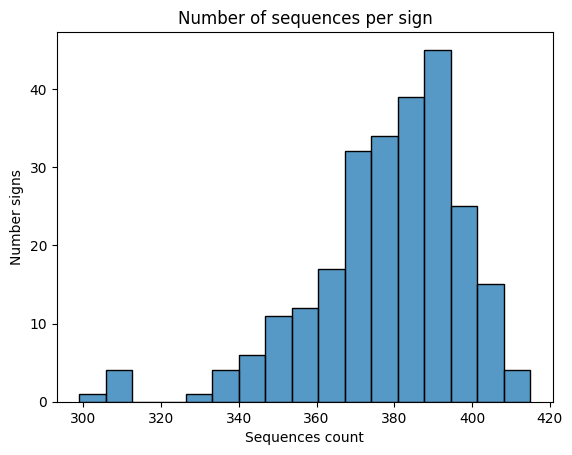

In [120]:
sns.histplot(train[['sign']].value_counts())
plt.title('Number of sequences per sign')
plt.xlabel('Sequences count')
plt.ylabel('Number signs');

## List of signs

In [12]:
labels_df = pd.read_json(LABEL_MAP_PATH, orient='index').reset_index().set_index(0).rename(columns={'index':'sign'})
labels_df.index.rename('index', inplace=True)
labels_df

,sign
index,
0,TV
1,after
2,airplane
3,all
4,alligator
...,...
245,yesterday
246,yourself
247,yucky


## Analysis of landmark files

In [13]:
train['file_path'] = str(DATA_DIR) + '/' + train['path']

In [14]:
train.loc[0, "file_path"]

'../../raw_data/asl-signs/train_landmark_files/26734/1000035562.parquet'

In [16]:
landmarks = pd.read_parquet(train.loc[0, "file_path"])
landmarks

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,0.643799,-0.123488


In [17]:
unique_frames = landmarks["frame"].nunique()
unique_types = landmarks["type"].nunique()

print(f"This file has total of {unique_frames} unique frames")
print(
    f"This file has total of {unique_types} unique types which contain {landmarks['type'].unique()}"
)

This file has total of 23 unique frames
This file has total of 4 unique types which contain ['face' 'left_hand' 'pose' 'right_hand']


In [149]:
def filter_relevant_landmarks(file_path):
    """Filter out face landmarks from parquet file"""
    landmarks = pd.read_parquet(file_path)
    filtered_landmarks = landmarks[landmarks['type'] != 'face']
    return filtered_landmarks

def write_light_parquet_file(parquet_file_path, filename_suffix=""):
    filtered_landmarks = filter_relevant_landmarks(parquet_file_path)
    new_parquet_file_path = get_light_parquet_path(parquet_file_path)
    file_path = Path(parquet_file_path)
    new_parquet_file_name = file_path.stem + suffix + file_path.suffix
    new_parquet_file_path = file_path.parent / new_parquet_file_name
    print(new_parquet_file_path)
    filtered_landmarks.to_parquet(new_parquet_file_path)

def write_light_parquet_files(parquet_file_list):
    for parquet_file_path in parquet_file_list:
        try:
            write_light_parquet_file(parquet_file_path)
        except Exception as e:
            print(f"Error processing {parquet_file_path}: {e}")

if __name__ == "__main__":
    file_list = ["../raw_data/google/train_landmark_files/26734/1000035562.parquet"]
    write_light_parquet_files(file_list)

Error processing ../raw_data/google/train_landmark_files/26734/1000035562.parquet: name 'get_light_parquet_path' is not defined


In [11]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [20]:
relevant_landmarks = load_relevant_data_subset(train.loc[0, "file_path"])
relevant_landmarks

array([[[ 0.49440014,  0.38046983, -0.03062646],
        [ 0.49601725,  0.3507348 , -0.05756483],
        [ 0.5008185 ,  0.35934305, -0.03028346],
        ...,
        [ 0.31373617,  0.41234398, -0.05269891],
        [ 0.35072815,  0.39958185, -0.06021732],
        [ 0.38579622,  0.4011007 , -0.06471767]],

       [[ 0.5011503 ,  0.38055426, -0.03156953],
        [ 0.49290648,  0.3493601 , -0.05817606],
        [ 0.49832708,  0.3581275 , -0.03118932],
        ...,
        [ 0.33588555,  0.3889878 , -0.0631762 ],
        [ 0.37742943,  0.3802519 , -0.07176355],
        [ 0.41639116,  0.38289747, -0.076529  ]],

       [[ 0.49847096,  0.37949273, -0.0309729 ],
        [ 0.49176967,  0.34847346, -0.05721497],
        [ 0.49767977,  0.3573629 , -0.03084622],
        ...,
        [ 0.35855788,  0.3844513 , -0.06097187],
        [ 0.4005313 ,  0.37769613, -0.07045607],
        [ 0.43907768,  0.37987   , -0.07860945]],

       ...,

       [[ 0.5357876 ,  0.37571952, -0.04070858],
        [ 0

In [21]:
relevant_landmarks.shape # number of frames, number of landmarks, # coordinates (x, y, z)

(23, 543, 3)

In [25]:
train.head()

,path,participant_id,sequence_id,sign,file_path
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,../raw_data/google/train_landmark_files/26734/...
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,../raw_data/google/train_landmark_files/28656/...
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,../raw_data/google/train_landmark_files/16069/...
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,../raw_data/google/train_landmark_files/25571/...
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,../raw_data/google/train_landmark_files/62590/...


In [77]:
i = 0

file_path = train["file_path"][i]
landmark = pd.read_parquet(file_path)

landmark

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,0.643799,-0.123488


In [78]:
landmark.describe()

,frame,landmark_index,x,y,z
count,12489.000000,12489.000000,11754.000000,11754.000000,11754.000000
mean,31.000000,202.994475,0.536739,0.383747,-0.035692
std,6.633515,146.796096,0.099322,0.221564,0.278528
min,20.000000,0.000000,-0.031811,0.224151,-2.782624
25%,25.000000,60.000000,0.485905,0.303034,-0.025137
50%,31.000000,196.000000,0.528092,0.345610,-0.006548
75%,37.000000,332.000000,0.578304,0.395295,0.015528
max,42.000000,467.000000,1.294350,2.147826,1.910815


In [80]:
landmark.isna().sum()

frame               0
row_id              0
type                0
landmark_index      0
x                 735
y                 735
z                 735
dtype: int64

In [85]:
landmark.type.value_counts()

type
face          10764
pose            759
left_hand       483
right_hand      483
Name: count, dtype: int64

In [118]:
landmark.type.value_counts(normalize=True)

type
face          0.861878
pose          0.060773
left_hand     0.038674
right_hand    0.038674
Name: proportion, dtype: float64

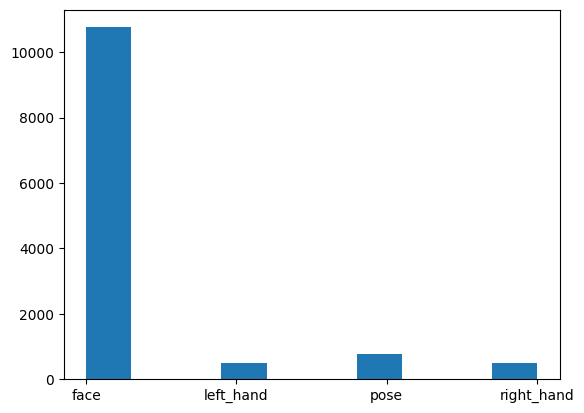

In [90]:
plt.hist(landmark.type);

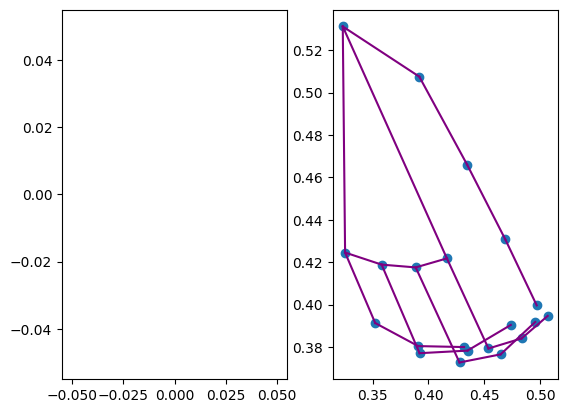

In [114]:
import mediapipe as mp

mp_hands = mp.solutions.hands

plt.figure;

frame = 25

plt.subplot(1, 2, 1)
hand = 'left_hand'
hand_landmark = landmark.query("frame == @frame and type == @hand")

plt.scatter(hand_landmark["x"], hand_landmark["y"]);

plt.subplot(1, 2, 2)
hand = 'right_hand'
hand_landmark = landmark.query("frame == @frame and type == @hand")

plt.scatter(hand_landmark["x"], hand_landmark["y"]);

for connection in mp_hands.HAND_CONNECTIONS:
        point_a = connection[0]
        point_b = connection[1]
        x1, y1 = hand_landmark.query("landmark_index == @point_a")[["x", "y"]].values[0]
        x2, y2 = hand_landmark.query("landmark_index == @point_b")[["x", "y"]].values[0]
        plt.plot([x1, x2], [y1, y2], color="purple")


![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*xw6ZOBpDqSxE8JhP8SJqBw.png)

In [116]:
mp_hands.HAND_CONNECTIONS

frozenset({(0, 1),
           (0, 5),
           (0, 17),
           (1, 2),
           (2, 3),
           (3, 4),
           (5, 6),
           (5, 9),
           (6, 7),
           (7, 8),
           (9, 10),
           (9, 13),
           (10, 11),
           (11, 12),
           (13, 14),
           (13, 17),
           (14, 15),
           (15, 16),
           (17, 18),
           (18, 19),
           (19, 20)})

### Landmarks visualization (animation)

In [15]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x],
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x],
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x],
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y],
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y],
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y],
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]]

    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x],
         [pose.iloc[10].x, pose.iloc[9].x],
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x,
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x],
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x],
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x],
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y],
         [pose.iloc[10].y, pose.iloc[9].y],
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y,
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y],
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y],
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y],
         [pose.iloc[24].y, pose.iloc[23].y]
        ]

    return x, y

In [16]:
sign = data
sign.y = sign.y * -1 # reverse vertically

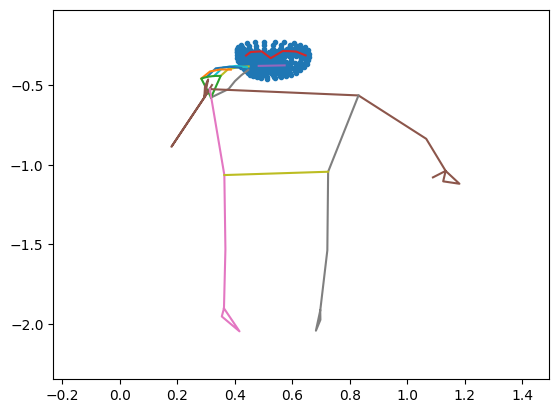

In [17]:
def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots(1)
l, = ax.plot([], [])
animation = FuncAnimation(fig,
                          func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())